$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd
from scipy.io import loadmat # loading data from matlab

%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-09-14 07:28:57.292556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Hidden Markov Model and LQR
This is an example of learning a HMM over some trajectories demonstrations and reproducing it using optimal control.
More infos : http://calinon.ch/papers/Calinon-JIST2015.pdf 


## Learning Hidden Markov Model (HMM)

In [25]:
datapath = os.path.dirname(pbd.__file__) + '/data/gui/'
data = np.load(datapath + 'test_001.npy',allow_pickle=True,encoding="latin1")[()] 
# adding encoding="latin1" for reading Python2 objects.

In [26]:
demos_x = data['x']  #Position data
demos_dx = data['dx'] # Velocity data
demos_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(demos_x, demos_dx)] # Position-velocity

In [27]:
np.array(demos_xdx[1]).shape

(90, 4)

Note: The demonstrations can have different length.

# Time aligning

#### Original trajectories 

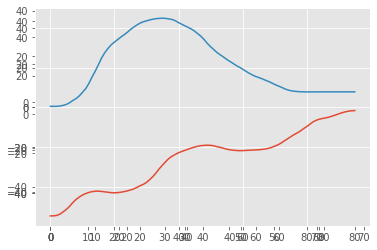

In [28]:
fig = plt.figure()
i = 0
for d in demos_x:
    plt.axes().set_prop_cycle(None)
    i+=1
    plt.plot(d)

#### Original trajectories 

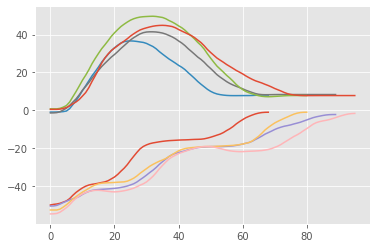

array([[-49.92285927,  -0.90419246],
       [-49.6049348 ,  -0.90741244],
       [-49.394423  ,  -0.8871208 ],
       [-49.03864313,  -0.81866677],
       [-48.42258351,  -0.66829248],
       [-47.76867495,  -0.35772417],
       [-46.55990122,   0.90623075],
       [-44.81680546,   3.01712665],
       [-43.29372724,   5.11783773],
       [-42.04096317,   7.5731987 ],
       [-40.91631263,  10.37335014],
       [-40.01503889,  12.97072883],
       [-39.38883394,  15.63577729],
       [-39.01953979,  18.26114251],
       [-38.7617622 ,  20.47171917],
       [-38.43869966,  22.84690014],
       [-38.05635783,  25.43639523],
       [-37.73005678,  27.57230619],
       [-37.12529358,  29.53842996],
       [-36.15887828,  31.47392857],
       [-35.17843503,  32.9937964 ],
       [-33.81277703,  34.32422764],
       [-32.11298354,  35.48128624],
       [-30.5420664 ,  36.20602809],
       [-28.63815186,  36.54067668],
       [-26.35189395,  36.62500364],
       [-24.23191909,  36.54426757],
 

In [29]:
fig = plt.figure()
i = 0
for d in demos_x:
#     plt.axes().set_prop_cycle(None)
    i+=1
    plt.plot(d)
plt.show()
demos_x[0]

In [30]:
demos_x, demos_dx, demos_xdx = pbd.utils.align_trajectories(demos_x, [demos_dx, demos_xdx]) 

t = np.linspace(0, 100, demos_x[0].shape[0])

#### Aligned trajectories and time

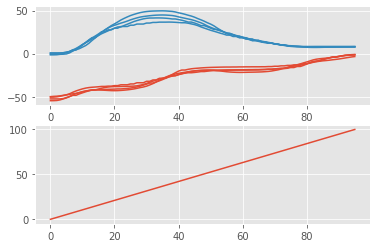

In [31]:
fig, ax = plt.subplots(nrows=2)
for d in demos_x:
    ax[0].set_prop_cycle(None)
    ax[0].plot(d)
    
ax[1].plot(t)

## Create augmented data with time 

In [32]:
demos = [np.hstack([t[:,None], d]) for d in demos_xdx]
data = np.vstack([d for d in demos])

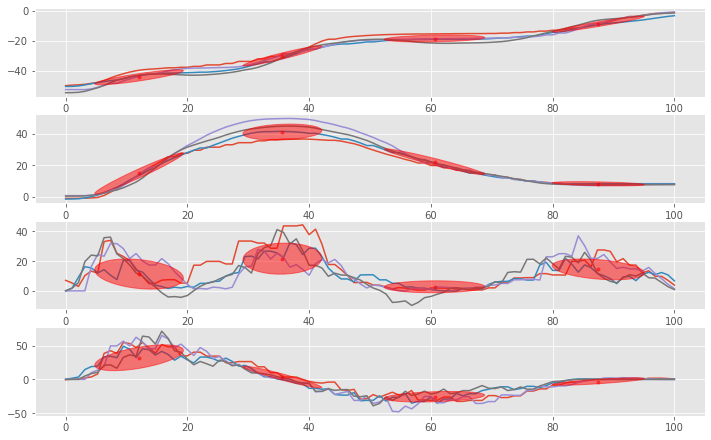

In [33]:
model = pbd.GMM(nb_states=4, nb_dim=5)

model.init_hmm_kbins(demos) # initializing model

# EM to train model
model.em(data, reg=[0.1, 1., 1., 1., 1.]) 


# plotting
fig, ax = plt.subplots(nrows=4)
fig.set_size_inches(12,7.5)

# position plotting

for i in range(4):

    for p in demos:
        ax[i].plot(p[:, 0], p[:, i + 1])

    pbd.plot_gmm(model.mu, model.sigma, ax=ax[i], dim=[0, i + 1]);


## Synthesis 

In [34]:
mu, sigma = model.condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(1, 5))

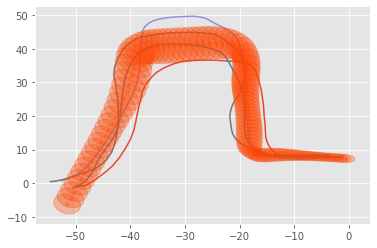

In [35]:
pbd.plot_gmm(mu, sigma, dim=[0, 1], color='orangered', alpha=0.3)

for d in demos_x:
    plt.plot(d[:, 0], d[:, 1])

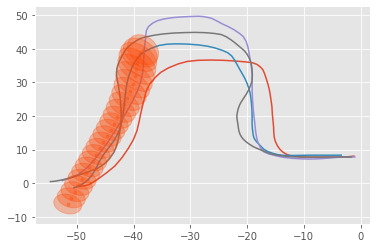

In [40]:
mu, sigma = model.condition(t[:-70, None], dim_in=slice(0, 1), dim_out=slice(1, 5))
pbd.plot_gmm(mu, sigma, dim=[0, 1], color='orangered', alpha=0.3)

for d in demos_x:
    plt.plot(d[:, 0], d[:, 1])